In [577]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.sparse import csr_matrix
from drawnow import drawnow
%matplotlib inline 
import sys
sys.setrecursionlimit(10000) 

In [665]:
class Board:
    def __init__(self,n,beta):
        self.n = n
        self.beta = beta
        self.board = np.zeros((n,n))
        self.edges = self.original_edge()
        self.tmp_clique = np.zeros((self.n,self.n))
    def original_edge(self):
        edge = np.zeros((self.n**2,self.n**2))
        n = self.n
        for i in range(n*n-1):
            if (i+1)%n !=0:
                edge[i+1,i] = 1
                edge[i,i+1] = 1
            if i%n != 0:
                edge[i-1,i] = 1
                edge[i,i-1] = 1
            if i>=n:
                edge[i,i-n] = 1
                edge[i-n,i] = 1
            if i<n*n - n:
                edge[i,i+n] = 1
                edge[i+n,i] = 1
        return edge
    def remove_edge(self,index1,index2):
        self.edges[index1,index2] = 0
        self.edges[index2,index1] = 0
    def become_checkerboard(self):
        for i in range(self.n):
            for j in range(self.n):
                self.board[i,j] = (i+j)%2
    def check_same_color(self):
        for i in range(self.n):
            for j in range(self.n):
                if j < self.n-1:
                    if self.board[i,j] != self.board[i,j+1]:
                        self.remove_edge(i*self.n + j, i*self.n + j+1)
                if i < self.n-1:
                    if self.board[i,j] != self.board[i+1,j]:
                        self.remove_edge(i*self.n + j, (i+1)*self.n + j)
    def clique(self):
        for i in range(self.n):
            for j in range(self.n):
                index = i*self.n + j
                if self.is_edge(i,j,i+1,j):
                    if np.random.uniform()<np.exp(-self.beta):
                        self.remove_edge(index,index+self.n)
                if self.is_edge(i,j,i,j+1):
                    if np.random.uniform()<np.exp(-self.beta):
                        self.remove_edge(index,index+1)

                        
    def clique_to_class(self):
        self.classes = np.zeros((self.n,self.n))
        self.found = np.zeros((self.n,self.n))
        class_tmp = 1
        for i in range(self.n):
            for j in range(self.n):
                if self.classes[i,j] ==0:
                    self.color_class(i,j,class_tmp)
                    class_tmp = class_tmp +1
        self.classn = class_tmp -1
    def is_edge(self,i,j,a,b):
        index1 = i*self.n + j
        index2 = a*self.n + b
        if index1<0 or index2<0:
            return False
        elif index1 >= self.n**2 or index2 >= self.n**2:
            return False
        elif self.edges[index1,index2] ==0:
            return False
        elif self.edges[index1,index2] ==1:
            return True
        
    def color_class(self,i,j,class_tmp):
        if(sum(sum(self.found))==self.n**2):
            return
        self.classes[i,j] = class_tmp
        self.found[i,j] =1
        if self.is_edge(i,j,i-1,j) and self.classes[i-1,j]==0 and self.found[i-1,j] ==0:
            #print i,' ',j,' to ',i-1,' ',j
            self.color_class(i-1,j,class_tmp)
        if self.is_edge(i,j,i+1,j) and self.classes[i+1,j]==0 and self.found[i+1,j] ==0:
            #print i,' ',j,' to ',i+1,' ',j
            self.color_class(i+1,j,class_tmp)
        if self.is_edge(i,j,i,j-1) and self.classes[i,j-1]==0 and self.found[i,j-1] ==0:
            #print i,' ',j,' to ',i,' ',j-1
            self.color_class(i,j-1,class_tmp)
        if self.is_edge(i,j,i,j+1) and self.classes[i,j+1]==0 and self.found[i,j+1] ==0:
            #print i,' ',j,' to ',i,' ',j+1
            self.color_class(i,j+1,class_tmp)
        return
    def flip_class(self):
        for i in range(1,self.classn+1):
            if np.random.uniform()>=0.5:
                self.board[self.classes==i] = 1
            else:
                self.board[self.classes==i] = 0
    def H(self):
        result = 0.0
        n = self.n
        for i in range(self.n):
            for j in range(self.n):
                if i<n-1:
                    if self.board[i,j] != self.board[i+1,j]:
                        result += 1.0
                if i>0:
                    if self.board[i,j] != self.board[i-1,j]:
                        result += 1.0
                if j<n-1:
                    if self.board[i,j] != self.board[i,j+1]:
                        result += 1.0
                if j>0:
                    if self.board[i,j] != self.board[i,j-1]:
                        result += 1.0
        result = result /2.0/self.n**2
        return result
    def Gibbs_cluster(self,itern,targeth,epsilon):
        H_list = np.zeros((1,itern))
        Avg_Size = np.zeros((1,itern))
        for i in range(itern):
            self.edges = self.original_edge()
            self.check_same_color()
            self.clique()
            self.clique_to_class()
            self.flip_class()
            H_list[0,i] = self.H()
            Avg_Size[0,i] = self.n**2/self.classn
            if(np.abs(H_list[0,i]-targeth)<epsilon):
                break
        #plt.figure()
        #plt.plot(range(i+1),H_list[0,0:(i+1)],linestyle='-',marker = 'o')
        #plt.ylabel('H(t)')
        #plt.xlabel('Sweeps')
        #plt.figure()
        #plt.plot(range(i+1),Avg_Size[0,0:(i+1)],linestyle='-',marker = 'o')
        #plt.ylabel('Average Clique Size')
        #plt.xlabel('Sweeps')
        #plt.figure()
        #self.plot_board()
        return H_list, Avg_Size,i
    def Gibbs_cluster2(self, itern,targeth,epsilon):
        H_list = np.zeros((1,itern))
        Avg_Size = np.zeros((1,itern))
        Sweeps = np.zeros((1,itern))
        for i in range(itern):
            
            self.randomflip()
            H_list[0,i] = self.H()
            Avg_Size[0,i] = sum(sum(self.tmp_clique))
            if i>0:
                Sweeps[0,i] = Sweeps[0,i-1]+sum(sum(self.tmp_clique))/self.n**2
            else:
                Sweeps[0,i] = sum(sum(self.tmp_clique))/self.n**2
            if(np.abs(H_list[0,i]-targeth)<epsilon):
                break
        #plt.figure()
        #plt.plot(Sweeps[0,0:(i+1)],H_list[0,0:(i+1)],linestyle='-',marker = 'o')
        #plt.ylabel('H(t)')
        #plt.xlabel('Sweeps')
        #plt.figure()
        #plt.plot(Sweeps[0,0:(i+1)],Avg_Size[0,0:(i+1)],linestyle='-',marker = 'o')
        #plt.ylabel('Average Clique Size')
        #plt.xlabel('Sweeps')
        return H_list, Avg_Size, Sweeps,i
    
    def randomflip(self):
        i = np.random.randint(0,self.n)
        j = np.random.randint(0,self.n)
        self.tmp_clique = np.zeros((self.n,self.n))
        self.growclique(i,j)
        if np.random.uniform()>=0.5:
            self.board[self.tmp_clique==1] = 1
        else:
            self.board[self.tmp_clique==1] = 0
    def is_same(self,i,j,a,b):
        if i<0 or j<0 or a<0 or b<0:
            return False
        elif i>=self.n or j>=self.n or a>=self.n or b>=self.n:
            return False
        elif self.board[i,j]==self.board[a,b]:
            return True
        else:
            return False
    def growclique(self,i,j):
        # Gives the clique of i and j
        self.tmp_clique[i,j] = 1
        if self.is_same(i,j,i-1,j) and self.tmp_clique[i-1,j] ==0:
            if np.random.uniform()>np.exp(-self.beta):
                self.growclique(i-1,j)
        if self.is_same(i,j,i+1,j) and self.tmp_clique[i+1,j] ==0:
            if np.random.uniform()>np.exp(-self.beta):
                self.growclique(i+1,j)
        if self.is_same(i,j,i,j-1) and self.tmp_clique[i,j-1] ==0:
            if np.random.uniform()>np.exp(-self.beta):
                self.growclique(i,j-1)
        if self.is_same(i,j,i,j+1) and self.tmp_clique[i,j+1] ==0:
            if np.random.uniform()>np.exp(-self.beta):
                self.growclique(i,j+1)
        return
    def plot_board(self):
        plt.figure()
        plt.imshow(self.board)
    def plot_class(self):
        plt.figure()
        plt.imshow(self.classes)
                     
                
            

In [710]:
def PlotGibbs(beta,htarget,epsilon,version):
    a= Board(64,beta)
    if version ==1:
        H1, A1,i1 = a.Gibbs_cluster(100,htarget,epsilon)
    elif version ==2:
        H1, A1,S1,i1 = a.Gibbs_cluster2(100,htarget,epsilon)
    a = Board(64,beta)
    a.become_checkerboard()
    if version ==1:
        H2, A2,i2 = a.Gibbs_cluster(100,htarget,epsilon)
    elif version ==2:
        H2, A2,S2,i2 = a.Gibbs_cluster2(1700,htarget,epsilon)
    if version ==1:
        plt.figure()
        plt.plot(range(i1+1),H1[0,0:(i1+1)],linestyle='-',marker = 'o')
        plt.plot(range(i2+1),H2[0,0:(i2+1)],linestyle='-',marker = 'o')
        plt.ylabel('H(t)')
        plt.xlabel('Sweeps')
        plt.legend(['MC1','MC2'])
        plt.title('beta = %s  Gibbs Sampling Version 1'%beta)
        #plt.annotate('convergence time = %s'%i1,xy=(i1,H1[0,i1]), xytext=(i1, H1[0,i1]+0.05),arrowprops=dict(facecolor='black', shrink=0.005))
        #plt.annotate('convergence time = %s'%i2,xy=(i2,H2[0,i2]), xytext=(i2, H2[0,i2]-0.05),arrowprops=dict(facecolor='black', shrink=0.005))
        plt.figure()
        plt.plot(range(i1+1),A1[0,0:(i1+1)],linestyle='-',marker = 'o')
        plt.plot(range(i2+1),A2[0,0:(i2+1)],linestyle='-',marker = 'o')
        plt.ylabel('Average Clique Size')
        plt.xlabel('Sweeps')
        plt.legend(['MC1','MC2'])
        plt.title('beta = %s  Gibbs Sampling Version 1'%beta)
        #plt.annotate('convergence time = %s'%i1,xy=(i1,A1[0,i1]), xytext=(i1, A1[0,i1]+1),arrowprops=dict(facecolor='black', shrink=0.005))
        #plt.annotate('convergence time = %s'%i2,xy=(i2,A2[0,i2]), xytext=(i2, A2[0,i2]-1),arrowprops=dict(facecolor='black', shrink=0.005))
        
    elif version ==2:
        plt.figure()
        plt.plot(S1[0,0:(i1+1)],H1[0,0:(i1+1)],linestyle='-',marker = 'o',alpha = 0.5,markerfacecolor="None")
        plt.plot(S2[0,0:(i2+1)],H2[0,0:(i2+1)],linestyle='-',marker = 'o',alpha = 0.5,markerfacecolor="None")
        plt.ylabel('H(t)')
        plt.xlabel('Sweeps')
        plt.legend(['MC1','MC2'])
        plt.title('beta = %s  Gibbs Sampling Version 2'%beta)
        #plt.annotate('convergence time = %s'%S1[0,i1],xy=(S1[0,i1],H1[0,i1]), xytext=(S1[0,i1], H1[0,i1]+0.05),arrowprops=dict(facecolor='black', shrink=0.005))
        #plt.annotate('convergence time = %s'%S2[0,i2],xy=(S2[0,i2],H2[0,i2]), xytext=(S2[0,i2], H2[0,i2]-0.05),arrowprops=dict(facecolor='black', shrink=0.005))
        plt.figure()
        
        plt.plot(S1[0,0:(i1+1)],A1[0,0:(i1+1)],linestyle='-',marker = 'o',alpha = 0.5,markerfacecolor="None")
        plt.plot(S2[0,0:(i2+1)],A2[0,0:(i2+1)],linestyle='-',marker = 'o',alpha = 0.5,markerfacecolor="None")
        plt.ylabel('Average Clique Size')
        plt.xlabel('Sweeps')
        plt.legend(['MC1','MC2'])
        plt.title('beta = %s  Gibbs Sampling Version 2'%beta)
        #plt.annotate('convergence time = %s'%S1[0,i1],xy=(S1[0,i1],A1[0,i1]), xytext=(S1[0,i1], A1[0,i1]+1),arrowprops=dict(facecolor='black', shrink=0.005))
        #plt.annotate('convergence time = %s'%S2[0,i2],xy=(S2[0,i2],A2[0,i2]), xytext=(S2[0,i2], A2[0,i2]-1),arrowprops=dict(facecolor='black', shrink=0.005))


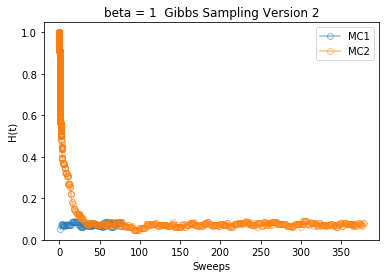

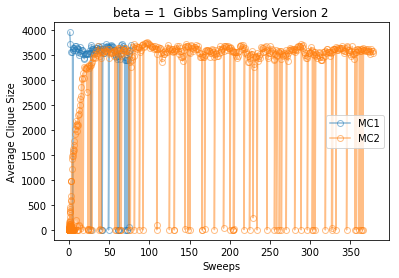

In [711]:
PlotGibbs(1,2,0,2)

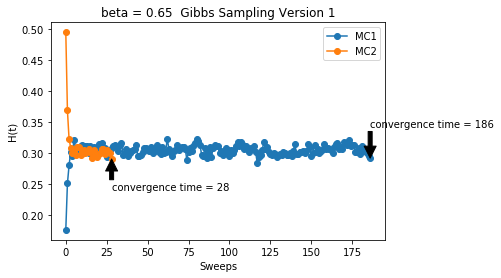

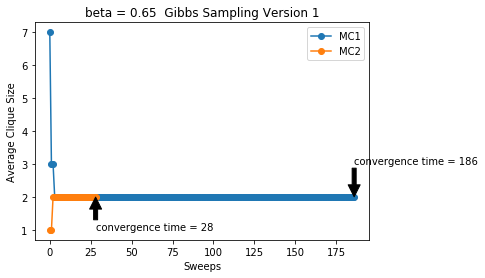

In [655]:
PlotGibbs(0.65,0.2904,0.001,1)

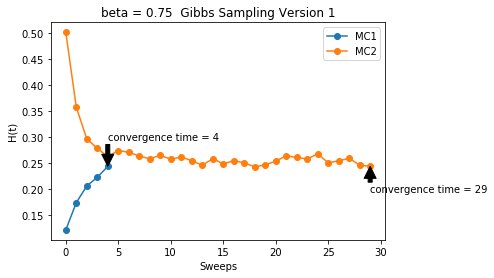

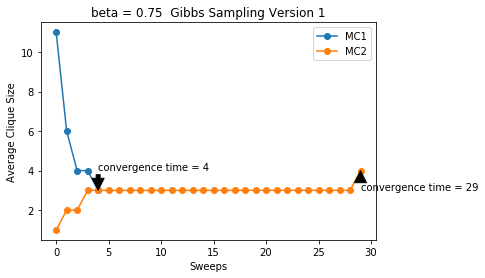

In [656]:
PlotGibbs(0.75,0.2445,0.001,1)

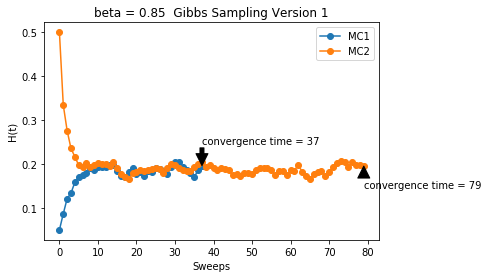

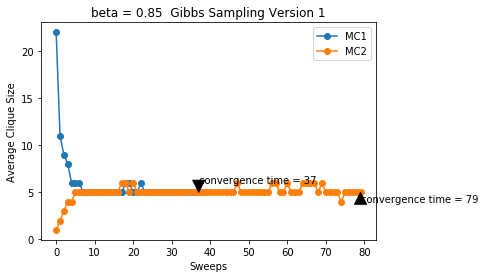

In [657]:
PlotGibbs(0.85,0.1963,0.001,1)

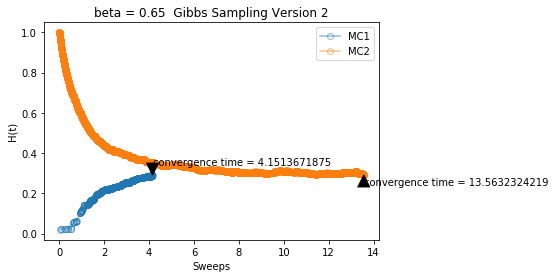

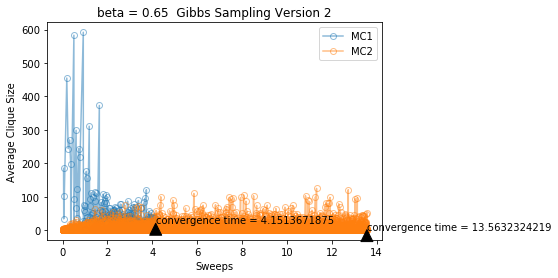

In [681]:
PlotGibbs(0.65,0.2904,0.001,2)

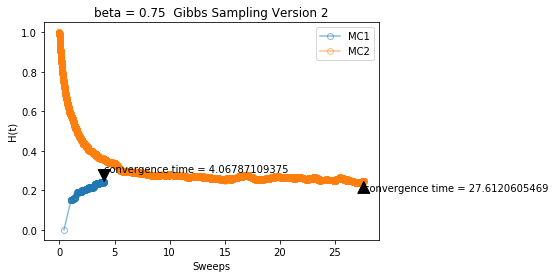

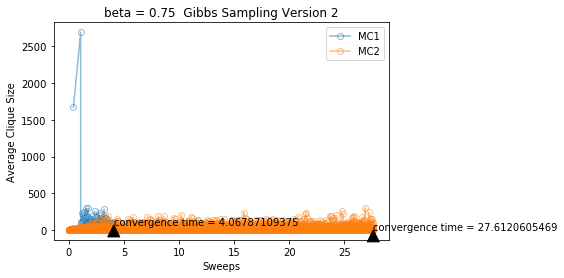

In [683]:
PlotGibbs(0.75,0.2445,0.001,2)

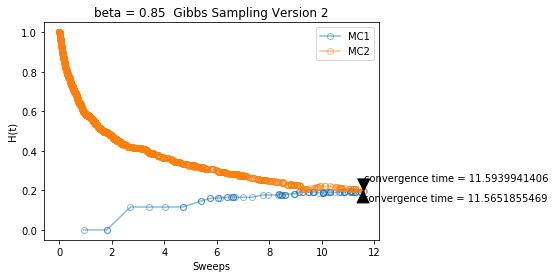

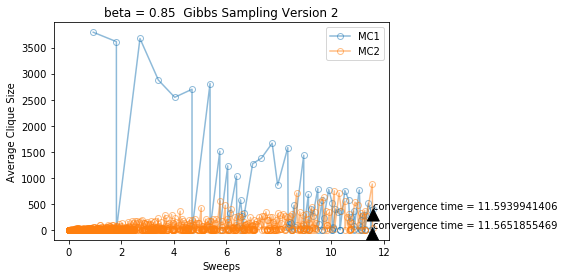

In [684]:
PlotGibbs(0.85,0.1963,0.001,2)

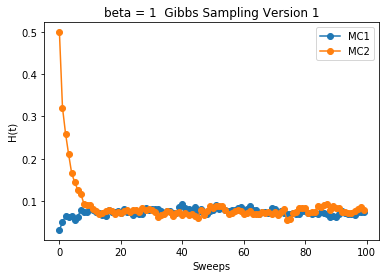

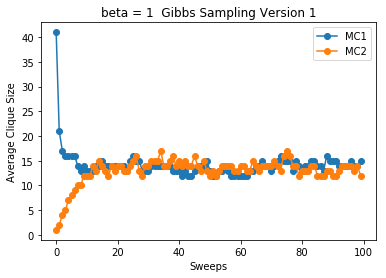

In [695]:
PlotGibbs(1,2,0,1)